### Filter out only PLGAs, Check for imbalance, Run LGBM and save.

In [1]:
import pandas as pd

df = pd.read_csv(r'D:\Bunker\OneDrive - Amrita vishwa vidyapeetham\BaseCamp\ML\PLAI\IMI_EndSem_Project\Gagabool\Conf_classified_separate.csv')

## Only PLGAs

In [3]:
plga_df = df[df['Release_Classification'] != 'Not PLGA']
plga_df = plga_df.reset_index(drop=True)
plga_df.to_csv('PLGA_only_dataset.csv', index=False)

## ImBalance Check

In [4]:
# Count of all unique values in a column named 'Release_Classification'
print(plga_df['Release_Classification'].value_counts())
df = plga_df

Release_Classification
Moderate    682
Slow        664
Fast        568
Name: count, dtype: int64


Yes there is imbalance.

#### Lets try to visualise

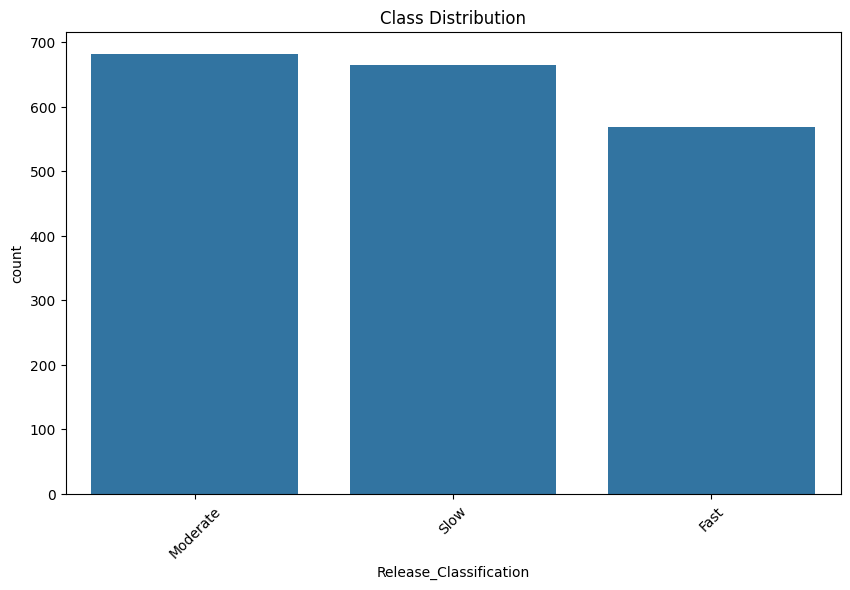

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Release_Classification', order=df['Release_Classification'].value_counts().index)
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

#### SMOTE SAMPLING:
💡 Core Idea Behind SMOTE:
Don’t duplicate minority examples (like vanilla oversampling).
Instead, synthesize new, similar but not identical, minority samples.

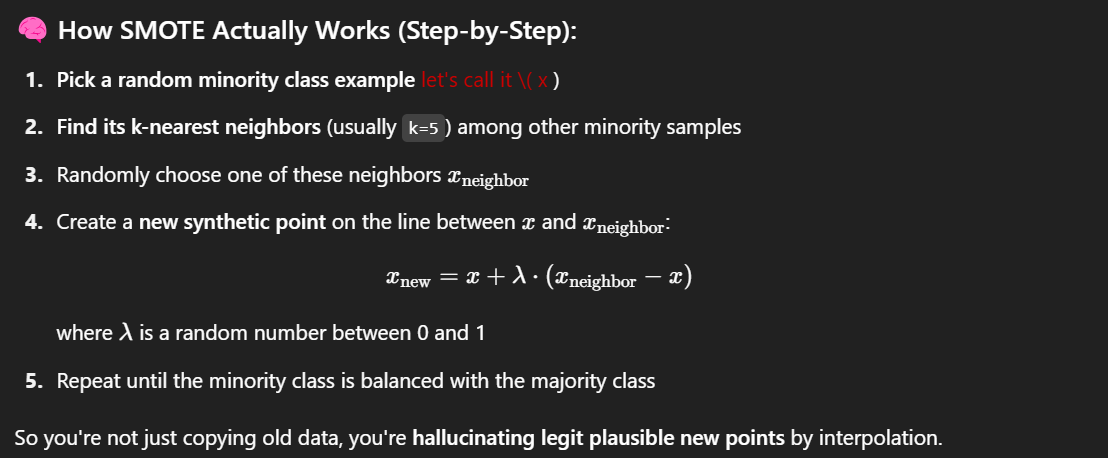


I used SMOTE over ADASYN because SMOTE generates synthetic samples in a more uniform and controlled way, reducing the risk of overfitting or creating noisy samples near decision boundaries — which is crucial for Siamese Neural Networks where clean, reliable embedding learning is key.

In [ ]:
from imblearn.over_sampling import SMOTE

# Define features to use
features = ['LA/GA', 'Polymer_MW', 'CL Ratio', 'Drug_Tm', 'Drug_Pka', 
			'Initial D/M ratio', 'DLC', 'SA-V', 'SE', 'Drug_Mw', 
			'Drug_TPSA', 'Drug_NHA', 'Drug_LogP', 'T=0.25', 'T=0.5', 'T=1.0z']

# Select features and target
X = df[features]
y = df['Release_Classification']  # Using the correct column name

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Original:", y.value_counts())
print("Resampled:", pd.Series(y_resampled).value_counts())

Original: Release_Classification
Moderate    682
Slow        664
Fast        568
Name: count, dtype: int64
Resampled: Release_Classification
Fast        682
Moderate    682
Slow        682
Name: count, dtype: int64


C:\Users\satya\AppData\Local\Temp\ipykernel_35512\1374575340.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
C:\Users\satya\AppData\Local\Temp\ipykernel_35512\1374575340.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')


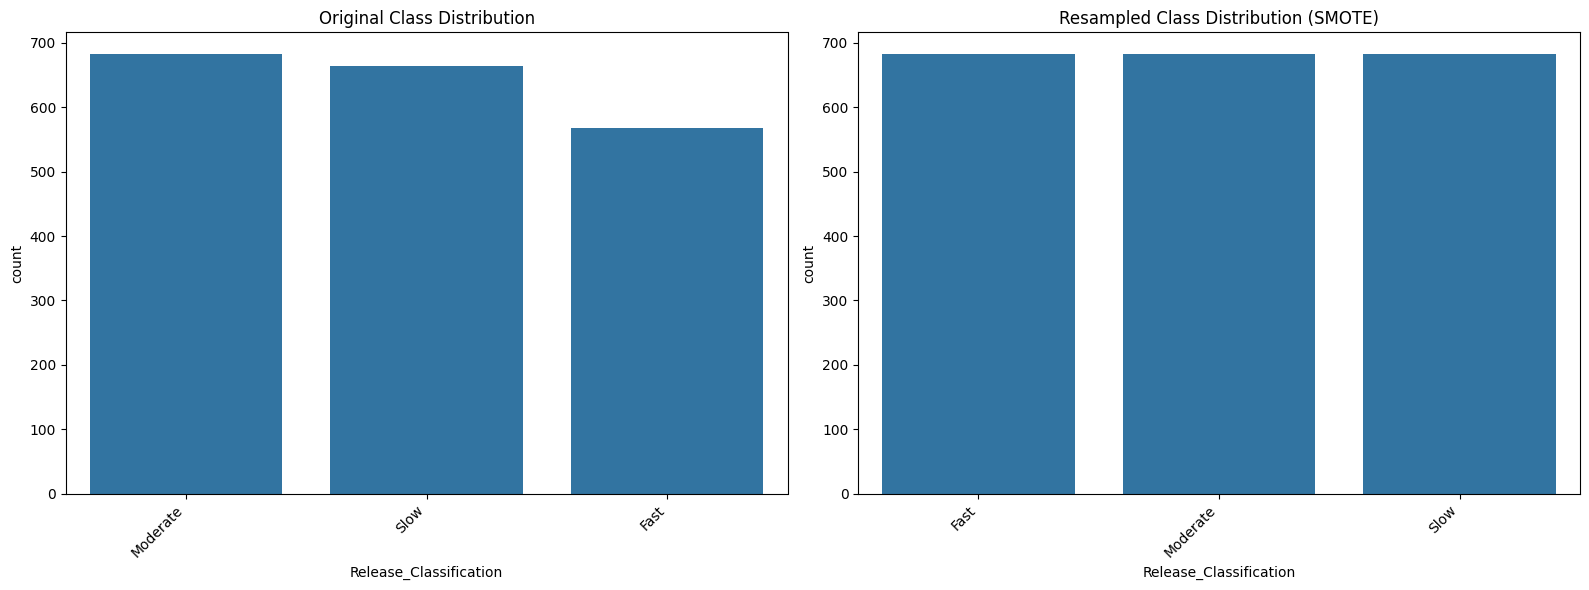

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot original distribution
sns.countplot(data=df, x='Release_Classification', order=df['Release_Classification'].value_counts().index, ax=ax1)
ax1.set_title('Original Class Distribution')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Plot resampled distribution
resampled_df = pd.DataFrame({'Release_Classification': y_resampled})
sns.countplot(data=resampled_df, x='Release_Classification', order=resampled_df['Release_Classification'].value_counts().index, ax=ax2)
ax2.set_title('Resampled Class Distribution (SMOTE)')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Create a dataframe with the resampled data and save to CSV
resampled_data = pd.DataFrame(X_resampled, columns=features)
resampled_data['Release_Classification'] = y_resampled
resampled_data.to_csv('resampled_plga_data.csv', index=False)

In [9]:
from sklearn.model_selection import train_test_split
import numpy as np


X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)
import lightgbm as lgb

model = lgb.LGBMClassifier(random_state=42)
model.fit(X_train, y_train)
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
import joblib
joblib.dump(model, 'lgbm_plga_model.pkl')


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 376
[LightGBM] [Info] Number of data points in the train set: 1636, number of used features: 16
[LightGBM] [Info] Start training from score -1.097391
[LightGBM] [Info] Start training from score -1.099224
[LightGBM] [Info] Start training from score -1.099224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

['lgbm_plga_model.pkl']

In [10]:
print("Input features:", list(X.columns))

Input features: ['LA/GA', 'Polymer_MW', 'CL Ratio', 'Drug_Tm', 'Drug_Pka', 'Initial D/M ratio', 'DLC', 'SA-V', 'SE', 'Drug_Mw', 'Drug_TPSA', 'Drug_NHA', 'Drug_LogP', 'T=0.25', 'T=0.5', 'T=1.0']


In [11]:
model = joblib.load('lgbm_plga_model.pkl')   
# Use only the 16 features that the model was trained on
sa_plga_features = np.array([[1, 12000, 0, 158.6, 2.79, 0.5, 0.016, 137.7198169, 0.5, 138.122, 57.53, 1.0904, 1, 0.744, 0.857, 0.857]])
ola_plga_features = np.array([[1, 46000, 0, 208.5, 9.96, 0.666666667, 0.2889, 73.98297135, 0.5, 434.471, 86.37, 2.3474, 3, 0.006, 0.008, 0.012]])

# Predict using the loaded model
sa_plga_pred = model.predict(sa_plga_features)
ola_plga_pred = model.predict(ola_plga_features)

print(f"SA-PLGA Prediction: {sa_plga_pred}")
print(f"OLA-PLGA Prediction: {ola_plga_pred}")

SA-PLGA Prediction: ['Fast']
OLA-PLGA Prediction: ['Slow']


c:\python\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\python\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
